tb - 7/5/2022 - Analyze the output of Jerry's first online runs comparing specific humidity and relative humidity across climates

# Imports

In [172]:
import cftime
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

In [175]:
fz = 15
lw = 2
siz = 100

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = lw
plt.rc('font',size=fz)

# Paths

In [2]:
path_folder = '/DFS-L/DATA/pritchard/tbeucler/For_Jerry/June2022_CI_Runs/'
Rescalings = ['sp','specificNN','relativeNN']
Climates = ['m4k','0k','p4k']

# Load all runs as `xarray` datasets

In [227]:
SP_Ref = {}; RHruns = {}; Qruns = {};

In [228]:
for clim in Climates:
    print(clim)
    SP_Ref[clim] = xr.open_mfdataset(path_folder+Rescalings[0]+'_'+clim+'/A*h1*.nc',
                             combine='nested',concat_dim='time')
    RHruns[clim] = {}; Qruns[clim] = {};
    
    for idropout in range(5):
        RHruns[clim][idropout] = {}; 
        Qruns[clim][idropout] = {}
        
        for BN in ['False','True']:
            
            path_RH = path_folder+Rescalings[2]+'_'+clim+\
            '/relhum_version_'+str(idropout)+'_'+BN
            path_Q = path_folder+Rescalings[1]+'_'+clim+\
            '/spehum_version_'+str(idropout)+'_'+BN
            
            RHruns[clim][idropout][BN] = xr.open_mfdataset(path_RH+'/A*h1*.nc',
                                                           combine='nested',concat_dim='time')
            Qruns[clim][idropout][BN] = xr.open_mfdataset(path_Q+'/A*h1*.nc',
                                                          combine='nested',concat_dim='time')

m4k
0k
p4k


# Compare all runs to SP reference

## Calculate mean climate from SP

In [229]:
SP_Ref[clim]['NNQBP'].shape

(366, 30, 64, 128)

lat/lon/z mean

In [230]:
MeanClim = {}

In [231]:
for clim in Climates:
    print(clim)
    MeanClim[clim] = {}
    
    MeanClim[clim]['Q'] = np.mean(SP_Ref[clim]['NNQBP'].values,axis=0)
    MeanClim[clim]['T'] = np.mean(SP_Ref[clim]['NNTBP'].values,axis=0)

m4k
0k
p4k


In [232]:
datetimeindex = SP_Ref[clim]['time'].values
new_datetime = []
for i,cfdat in enumerate(datetimeindex):
    new_datetime.append(
        np.datetime64(
        '%04.0f'%cfdat.year+'-'+'%02.0f'%cfdat.month+'-'+
        '%02.0f'%cfdat.day+' '+'%02.0f'%cfdat.hour+':'+
        '%02.0f'%cfdat.minute+':'+'%02.0f'%cfdat.second)
    )
new_datetime = np.array(new_datetime)
xt = []
for date in new_datetime:
    xt.append(np.timedelta64(date-new_datetime[0],'D'))
xt = np.float32(np.array(xt))

## Calculate drift from mean climate

In [233]:
RHdrift = {}; Qdrift = {}; SPdrift = {};

In [234]:
for clim in Climates:
    print(clim)
    RHdrift[clim] = {}; Qdrift[clim] = {}; SPdrift[clim] = {}
    
    SPdrift[clim]['Q'] = np.mean(SP_Ref[clim]['NNQBP'].values-MeanClim[clim]['Q'],axis=(1,2,3))
    SPdrift[clim]['T'] = np.mean(SP_Ref[clim]['NNTBP'].values-MeanClim[clim]['T'],axis=(1,2,3))
    
    for idropout in range(5):
        RHdrift[clim][idropout] = {}; 
        Qdrift[clim][idropout] = {}
        
        for BN in ['False','True']:
            
            RHdrift[clim][idropout][BN] = {}; 
            Qdrift[clim][idropout][BN] = {}
            
            RHdrift[clim][idropout][BN]['Q'] = \
            np.mean(RHruns[clim][idropout][BN]['NNQBP'].values-
                    MeanClim[clim]['Q'],axis=(1,2,3))
            RHdrift[clim][idropout][BN]['T'] = \
            np.mean(RHruns[clim][idropout][BN]['NNTBP'].values-
                    MeanClim[clim]['T'],axis=(1,2,3))
            Qdrift[clim][idropout][BN]['Q'] = \
            np.mean(Qruns[clim][idropout][BN]['NNQBP'].values-
                    MeanClim[clim]['Q'],axis=(1,2,3))
            Qdrift[clim][idropout][BN]['T'] = \
            np.mean(Qruns[clim][idropout][BN]['NNTBP'].values-
                    MeanClim[clim]['T'],axis=(1,2,3))

m4k
0k
p4k


In [238]:
Marker_array = ['o','s','+','*','x']
Label_array = ['Dropout = 0','Dropout = 0.1','Dropout = 0.2','Dropout = 0.3','Dropout = 0.4']

In [239]:
labelQ = ''; labelRH = ''; labelBN = ''; labelDP = '';

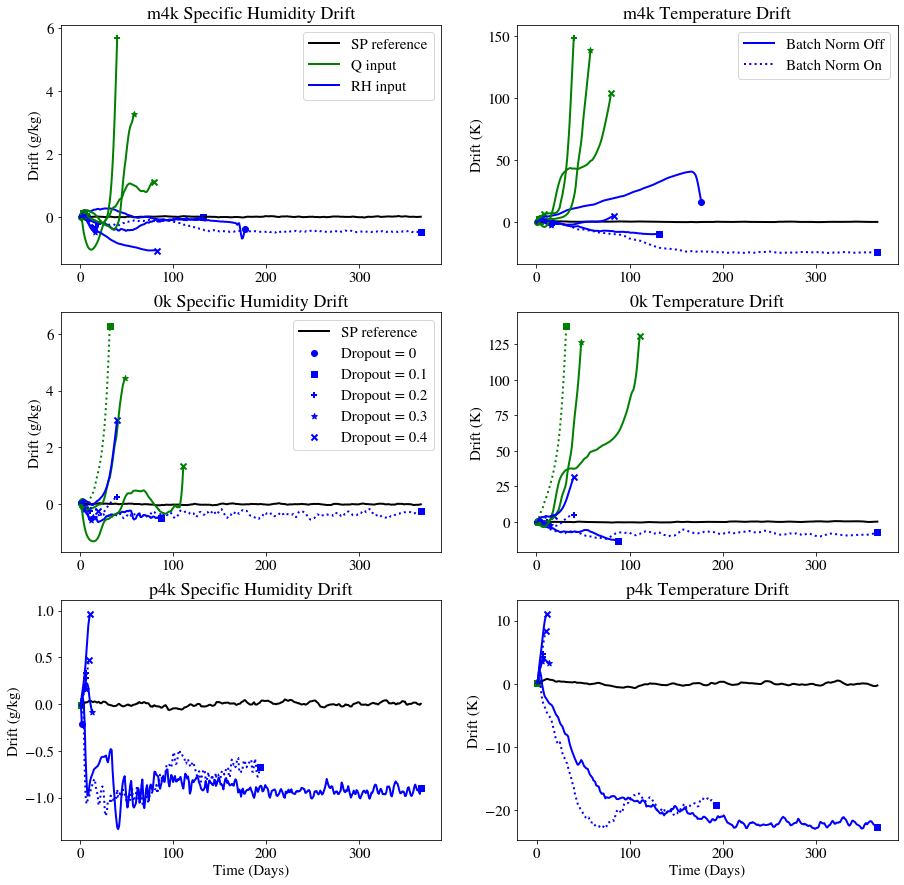

In [240]:
fig, ax = plt.subplots(3,2,figsize=(15,15))

for iclim,clim in enumerate(Climates):
    
    ax[iclim][0].plot(xt,1e3*SPdrift[clim]['Q'],color='k',label='SP reference')
    ax[iclim][1].plot(xt,SPdrift[clim]['T'],color='k')
    
    for idropout in range(5):
        
        marker = Marker_array[idropout]
        
        for BN in ['False','True']:
            
            if BN=='False': linestyle='-'
            else: linestyle=':'
            
            # Moisture drift plots
            
            if iclim==1 and BN=='False':
                labelDP = Label_array[idropout]
                labelQ = ''; labelRH = '';
            elif BN=='True': labelDP = '';
            elif iclim!=1: labelDP = ''
            
            if iclim==0 and idropout==0 and BN=='False':
                labelQ = 'Q input'
                labelRH = 'RH input'
            else: labelQ = ''; labelRH = '';
            
            yQ = Qdrift[clim][idropout][BN]
            yRH = RHdrift[clim][idropout][BN]
            LQ = len(yQ['Q']); LRH = len(yRH['Q']);
            
            ax[iclim][0].plot(xt[:LQ],1e3*yQ['Q'],
                              color='g',linestyle=linestyle,label=labelQ)
            ax[iclim][0].plot(xt[:LRH],1e3*yRH['Q'],
                              color='b',linestyle=linestyle,label=labelRH)
            ax[iclim][0].scatter(xt[LQ-1],1e3*yQ['Q'][LQ-1],
                                 color='g',marker=marker)
            ax[iclim][0].scatter(xt[LRH-1],1e3*yRH['Q'][LRH-1],
                                 color='b',marker=marker,label=labelDP)
            if idropout==0 and iclim==0: ax[iclim][0].legend()
            if iclim==1: ax[iclim][0].legend()
            
            ax[iclim][0].set_ylabel('Drift (g/kg)')
            if idropout==0 and BN=='False': 
                ax[iclim][0].set_title(clim+' Specific Humidity Drift')
            if iclim==2 and idropout==0 and BN=='False': 
                ax[iclim][0].set_xlabel('Time (Days)')
            
            # Temperature drift plots
            
            if idropout==0:
                if BN=='True': labelBN = 'Batch Norm On' 
                else: labelBN = 'Batch Norm Off'
            else: labelBN = ''
            
            ax[iclim][1].plot(xt[:LQ],yQ['T'],
                              color='g',linestyle=linestyle)
            ax[iclim][1].plot(xt[:LRH],yRH['T'],
                              color='b',linestyle=linestyle,label=labelBN)
            ax[iclim][1].scatter(xt[LQ-1],yQ['T'][LQ-1],
                                 color='g',marker=marker)
            ax[iclim][1].scatter(xt[LRH-1],yRH['T'][LRH-1],
                                 color='b',marker=marker)
            if idropout==0 and iclim==0: ax[iclim][1].legend()
            
            ax[iclim][1].set_ylabel('Drift (K)')
            if idropout==0 and BN=='False': 
                ax[iclim][1].set_title(clim+' Temperature Drift')
            if iclim==2 and idropout==0 and BN=='False': 
                ax[iclim][1].set_xlabel('Time (Days)')